In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter

In [43]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [44]:
path = r"../data/labour-force-survey"
df_raw = load_df(path, skip_rows=5)

In [45]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [46]:
# reshape wide → long
def prep_ons_emp_table(df_raw: pd.DataFrame,
                       sectors=None,
                       period_col="Period", 
                       start_year=None, 
                       end_year=None) -> pd.DataFrame:
    """
    Takes the ONS EMP13-style table (wide by sector) and returns
    df_plot with columns: Year, Sector, Number (in thousands).
    """
    if sectors is None:
        sectors = [
            "Construction",
            "Manufacturing",
            "Mining, energy and water supply",
            "Education",
        ]

    df = df_raw.copy()

    # Clean column names (strip trailing footnote digits like "2", "3")
    def clean_col(c):
        return re.sub(r"\d+$", "", str(c)).strip()
    df.columns = [clean_col(c) for c in df.columns]

    # Keep only Period + sectors present
    have = [c for c in sectors if c in df.columns]
    missing = [c for c in sectors if c not in df.columns]
    if missing:
        print("Warning: missing sector columns:", missing)
    df = df[[period_col] + have].copy()

    # Extract Year from "Apr-Jun 2019" etc.
    df["Year"] = df[period_col].astype(str).str.extract(r"(\d{4})").astype(float)
    df = df.dropna(subset=["Year"]).copy()
    df["Year"] = df["Year"].astype(int)

    # Coerce to numeric: handle "..", commas, whitespace
    for c in have:
        col = (df[c]
               .replace({"..": np.nan})
               .astype(str)
               .str.replace(",", "", regex=False)
               .str.strip())
        df[c] = pd.to_numeric(col, errors="coerce")

    # Long/tidy
    long = df.melt(id_vars=["Year"], value_vars=have,
                   var_name="Sector", value_name="Number")

    # Annualise across quarters (mean is standard for employment stocks)
    df_plot = (long
               .groupby(["Year", "Sector"], as_index=False)["Number"]
               .mean()
               .dropna(subset=["Number"]))
    
    if start_year is not None:
        df_plot = df_plot[df_plot["Year"] >= int(start_year)]
    if end_year is not None:
        df_plot = df_plot[df_plot["Year"] <= int(end_year)]
    
    return df_plot


In [47]:
# clustered bars by Year (x-axis)
def plot_clustered_by_year(df_plot: pd.DataFrame,
                           title: str,
                           out_basename: str,
                           chart_dir: str = "chart-6",
                           sector_order=None,
                           year_order=None,
                           cluster_gap=0.25):
    """
    df_plot columns: Year, Sector, Number (thousands).
    x-axis = Year. For each Year, show bars for each Sector.
    """

    # Choose orders
    if sector_order is None:
        sector_order = sorted(df_plot["Sector"].unique().tolist())
    if year_order is None:
        year_order = sorted(df_plot["Year"].unique().tolist())

    # Pivot to Year x Sector
    pvt = (df_plot
           .pivot_table(index="Year", columns="Sector", values="Number", aggfunc="mean")
           .reindex(index=year_order)
           .reindex(columns=sector_order))

    # Remove years that are all-NaN
    pvt = pvt.dropna(how="all")

    # Build figure
    fig, ax = plt.subplots(figsize=(max(10, 0.5*len(pvt.index)*len(pvt.columns)), 6))

    years = pvt.index.to_list()
    x = np.arange(len(years))
    n_groups = len(sector_order)
    bar_w = 0.8 / max(n_groups, 1)

    # Colors (distinct, readable)
    palette = [
        "#2E86AB",  # Manufacturing
        "#F18F01",  # Construction
        "#6C7A89",  # Mining/Energy/Water
        "#8E44AD",  # Education
    ]
    color_map = {s: palette[i % len(palette)] for i, s in enumerate(sector_order)}

    # Draw bars cluster-by-cluster
    for i, sec in enumerate(sector_order):
        if sec not in pvt.columns:
            continue
        vals = pvt[sec].values
        # Replace NaN with 0 for plotting
        vals_plot = np.nan_to_num(vals, nan=0.0)

        ax.bar(x + i*bar_w - 0.5*bar_w*(n_groups-1),
               vals_plot, width=bar_w, label=sec, color=color_map[sec])

    # Labels/formatting
    ax.set_title(title, fontweight="bold", pad=12)
    ax.set_xlabel("Year")
    ax.set_ylabel("People in employment (thousands)", fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels([str(y) for y in years], rotation=30, ha="right")

    # Nice y formatting
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    # Legend outside
    ax.legend(title="Sector", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    # Headroom (guard against all-NaN)
    ymax = np.nanmax(pvt.values) if np.isfinite(np.nanmax(pvt.values)) else 1.0
    ax.set_ylim(0, ymax*1.12 if ymax > 0 else 1)

    plt.tight_layout()

    # Save (reuse your save_or_show if you like)
    try:
        from utils.common_functions import save_or_show
        save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)
    except Exception:
        plt.show()





In [48]:
sectors = [
    "Construction",
    "Manufacturing",
    "Mining, energy and water supply",
    # "Education",
]


df_plot = prep_ons_emp_table(df_raw, sectors=sectors, start_year=2014)



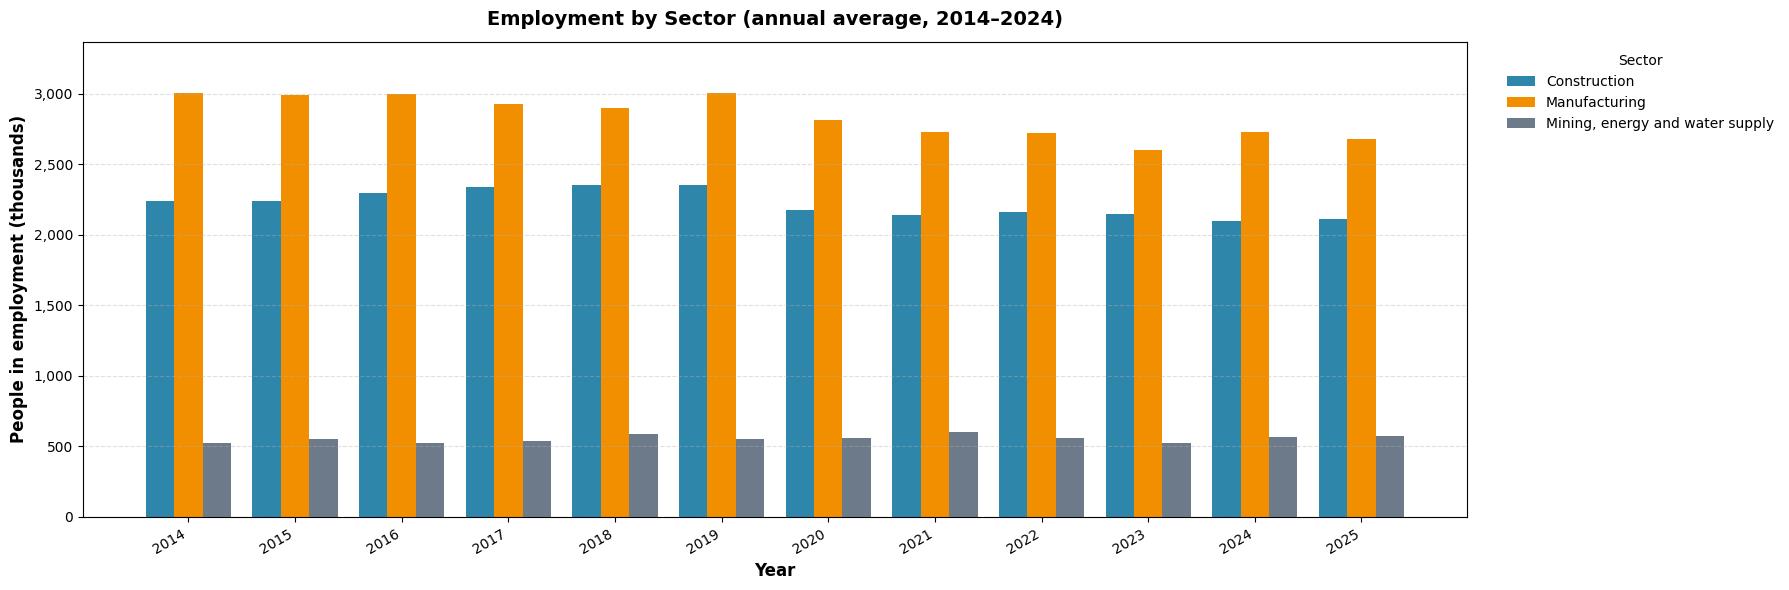

In [49]:
plot_clustered_by_year(
    df_plot,
    title="Employment by Sector (annual average, 2014–2024)",
    out_basename="employment_by_sector_year_clusters",
    chart_dir="chart-6",
    sector_order=sectors,
    year_order=sorted(df_plot["Year"].unique()),
    cluster_gap=0.1
)

### Multi-Line Chart

In [50]:
_QMAP = {
    "Jan-Mar": ("Q1", 1),
    "Apr-Jun": ("Q2", 2),
    "Jul-Sep": ("Q3", 3),
    "Oct-Dec": ("Q4", 4),
}
_PERIOD_RE = re.compile(r"(Jan-Mar|Apr-Jun|Jul-Sep|Oct-Dec)\s+(\d{4})")
def _parse_period(s: str):
    m = _PERIOD_RE.search(str(s))
    if not m:
        return None, None, None
    qm, year = m.group(1), int(m.group(2))
    qlabel, qidx = _QMAP[qm]
    return year, qlabel, qidx

In [51]:
def infer_sector_columns(df, period_col="Period", exclude_aggregates=True):
    # Clean trailing footnote digits in headers for matching
    cols = [re.sub(r"\d+$", "", str(c)).strip() for c in df.columns]
    tmp = df.copy()
    tmp.columns = cols

    exclude = {period_col}
    if exclude_aggregates:
        exclude |= {"All in employment", "Public sector", "Private sector"}

    # Candidate sector columns = everything except excluded + must be numeric-ish in at least some rows
    candidates = []
    for c in tmp.columns:
        if c in exclude: 
            continue
        # quick numeric check after removing commas and ".."
        s = (tmp[c].astype(str)
                     .str.replace(",", "", regex=False)
                     .str.strip()
                     .replace({"..": np.nan}))
        try:
            num = pd.to_numeric(s, errors="coerce")
            if num.notna().sum() > 0:
                candidates.append(c)
        except Exception:
            pass
    return candidates


In [52]:
def prep_ons_emp_quarterly(df_raw: pd.DataFrame,
                           sectors=None,                 # None => infer
                           period_col="Period",
                           start_year=None,
                           end_year=None,
                           include_aggregates=False):    # include All/Public/Private if True
    df = df_raw.copy()
    # normalize headers
    df.columns = [re.sub(r"\d+$", "", str(c)).strip() for c in df.columns]

    # auto-detect sectors if not provided
    if sectors is None:
        sectors = infer_sector_columns(df, period_col=period_col, exclude_aggregates=not include_aggregates)

    # keep only needed columns
    have = [c for c in sectors if c in df.columns]
    missing = [c for c in (sectors or []) if c not in df.columns]
    if missing:
        print("Warning: missing columns:", missing)
    df = df[[period_col] + have].copy()

    # parse year/quarter
    parsed = df[period_col].apply(_parse_period)
    df["Year"]    = parsed.apply(lambda t: t[0])
    df["Quarter"] = parsed.apply(lambda t: t[1])
    df["QIndex"]  = parsed.apply(lambda t: t[2])
    df = df.dropna(subset=["Year", "Quarter", "QIndex"]).copy()
    df["Year"]   = df["Year"].astype(int)
    df["QIndex"] = df["QIndex"].astype(int)

    # clean numerics
    for c in have:
        col = (df[c].replace({"..": np.nan})
                   .astype(str)
                   .str.replace(",", "", regex=False)
                   .str.strip())
        df[c] = pd.to_numeric(col, errors="coerce")

    # long / tidy
    long = (df
        .melt(id_vars=["Year", "Quarter", "QIndex"], value_vars=have,
              var_name="Sector", value_name="Number")
        .dropna(subset=["Number"])
        .sort_values(["Year", "QIndex"])
        .reset_index(drop=True)
    )

    # sequential x across quarters
    uq = long[["Year", "QIndex"]].drop_duplicates().reset_index(drop=True)
    uq["X"] = np.arange(len(uq))
    long = long.merge(uq, on=["Year", "QIndex"], how="left")
    long["YearQ"] = long["Year"].astype(str) + " " + long["Quarter"]

    # optional slicing
    if start_year is not None:
        long = long[long["Year"] >= int(start_year)]
    if end_year is not None:
        long = long[long["Year"] <= int(end_year)]

    return long  # cols: Year, Quarter, QIndex, Sector, Number, X, YearQ

In [59]:
def plot_quarterly_lines(dfq: pd.DataFrame,
                         title: str,
                         ylabel: str = "People in employment (thousands)",
                         out_basename: str = "sector_quarterly_lines",
                         chart_dir: str = "chart-6",
                         sector_order=None,    # None => detect from dfq
                         show_legend=True,
                         legend_outside=True,
                         linewidth=1.4,
                         use_markers=False,
                         max_legend_cols=3, 
                         fig_width=None):
    if sector_order is None:
        sector_order = sorted(dfq["Sector"].unique().tolist())

    pvt = (dfq.pivot_table(index="X", columns="Sector", values="Number", aggfunc="mean")
              .reindex(columns=sector_order))

    publication_rc()
    # major ticks at Q1 of each year
    year_starts = (dfq[dfq["QIndex"].eq(1)]
                   .drop_duplicates(subset=["Year"])
                   .sort_values("Year"))
    major_pos = year_starts["X"].to_numpy()
    major_labels = year_starts["Year"].astype(int).astype(str).tolist()

    # minor ticks at every quarter
    all_pos = pvt.index.to_numpy()
    # figure sizing scales with number of quarters
    nx = len(pvt.index)
    fig_w = max(16, min(18, nx * 0.08))
    # if fig_width is None:
    #     fig_w = max(
    #         11,                    # minimum
    #         nx * 0.12,             # more aggressive growth by x-points
    #         12 + 0.6*len(sector_order)  # room for single-row legend
    #     )
    #     fig_w = min(fig_w, 36)      # sensible cap (increase if needed)
    # else:
    #     fig_w = fig_width

    fig, ax = plt.subplots(figsize=(fig_w, 6))

    # palette: cycle through tab20 for many lines
    from itertools import cycle
    colors = plt.cm.tab20.colors
    color_cyc = cycle(colors)

    for sec in pvt.columns:
        y = pvt[sec].to_numpy()
        ax.plot(
            pvt.index, y,
            linewidth=linewidth,
            marker="o" if use_markers else None,
            ms=2.5,
            label=sec,
            color=next(color_cyc)
        )

    ax.set_title(title, pad=14, fontsize=15)
    ax.set_xlabel("Year / Quarter")
    ax.set_ylabel(ylabel, fontweight="bold")

    ax.xaxis.set_major_locator(FixedLocator(major_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(major_labels))
    ax.xaxis.set_minor_locator(FixedLocator(all_pos))

    ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.6)
    ax.grid(True, which="minor", axis="x", linestyle=":",  alpha=0.2)


    ax.yaxis.set_major_locator(MultipleLocator(1000))
    ax.yaxis.set_minor_locator(MultipleLocator(250))
    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.6)
    ax.grid(True, which="minor", axis="y", linestyle=":",  alpha=0.2)

    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.5)

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    if show_legend:
        # if legend_outside:
        #     ncol = min(max_legend_cols, max(1, int(np.ceil(len(sector_order)/8))))
        #     ax.legend(title="Sector", loc="upper left", bbox_to_anchor=(1.02, 1),
        #               frameon=False, ncol=ncol)
        # else:
        #     ax.legend(frameon=False, loc="upper left")
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)

    plt.tight_layout()
    try:
        from utils.common_functions import save_or_show
        save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)
    except Exception:
        plt.show()

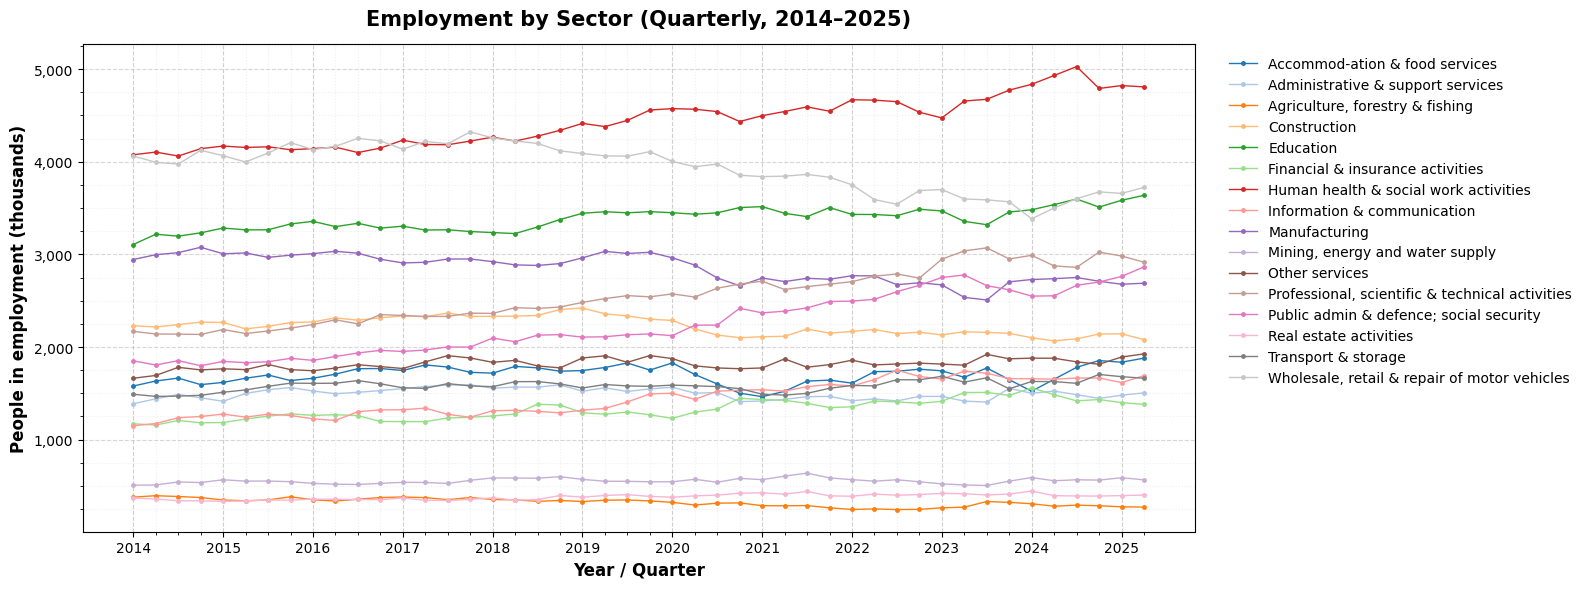

In [60]:
# If you want all sectors (excluding the aggregates by default):
dfq_all = prep_ons_emp_quarterly(df_raw, sectors=None, start_year=2014)

plot_quarterly_lines(
    dfq_all,
    title="Employment by Sector (Quarterly, 2014–2025)",
    out_basename="sector_quarterly_lines_all",
    chart_dir="chart-6",
    sector_order=None,        # None → use every sector column found
    show_legend=True,
    legend_outside=True,
    linewidth=1,
    use_markers=True       # turn on if you want points on each quarter
)

# If you also want to include the aggregate lines (All/Public/Private):
# dfq_all_inc_aggs = prep_ons_emp_quarterly(
#     df_raw, sectors=None, include_aggregates=True, start_year=2014
# )
